# 02750 HW4
## Anushka Sinha (anushka3)

## Exercise 1 Batch Selection

#### Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
import random
from sklearn.preprocessing import LabelEncoder
import tqdm
from sklearn.cluster import KMeans
from tqdm import tqdm

#### Data

In [2]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
data = pd.read_csv("iris/iris.data", header=None, names=column_names)
data_array = data.to_numpy()
shuffled_data = shuffle(data, random_state=42)
len(data)

150

In [3]:
random_seeds = []
for i in range(10):
    random.seed(100*i)
    random_seeds.append(random.randint(1, 100))
random_seeds

[50, 19, 6, 77, 40, 60, 34, 22, 86, 80]

## 1a. Greedy batch-wise selection criteria using uncertainty sampling

#### Passive Learning 

In [4]:
def batch_passive_learning(d, seed, batch_size):
    # Store average test accuracy using Unseen data
    test_acc = []
    d = shuffle(data, random_state=seed)

    # Start with five (5) random observations 
    test_size_fraction = 1 - (5 / len(d) )
    sample_data, remaining_data = train_test_split(d, test_size=test_size_fraction, random_state=seed)
    sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
    
    # Run the loop while the sample_data includes 50% of the original data
    while len(sample_data) <= len(d) /2 :
        
        # Predict on the unseen data
        X_train, y_train = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        X_test, y_test = remaining_data.iloc[:, :-1], remaining_data.iloc[:, -1]

        # Get the accuracy score on the unseen data 
        mod = RandomForestClassifier(random_state=None)
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_acc.append(test_accuracy)

        # Sample three random instances from 'remaining_data'
        instances_to_add = remaining_data.sample(n=batch_size)
        # Concatenate these instances to 'sample_data', reset the index to avoid index duplication
        sample_data = pd.concat([sample_data, instances_to_add], ignore_index=True)
        # Drop the sampled instances from 'remaining_data' using their indices
        remaining_data = remaining_data.drop(instances_to_add.index)
        

    return  test_acc


##### Active Learning (Uncertainty Sampling)

In [5]:
def get_entropies(labels_probs):
    entropies = [] 
    epsilon = 0.0001
    for i in labels_probs:
        prod = i * np.log2(i+epsilon)
        entropies.append(-np.sum(prod))
    return entropies
        

In [6]:
def batch_active_learning(d, seed, batch_size):
    test_acc = []
    d = shuffle(d, random_state=seed)

    # Start with five (5) random observations 
    test_size_fraction = 1- (5 / len(d)) 
    sample_data, remaining_data = train_test_split(d, test_size=test_size_fraction, random_state=seed)
    sample_data_X, sample_data_y = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]

    # Run the loop until the sample data includes 50% of the original data 
    while len(sample_data) <= len(d) / 2:

        # Training a model on the current sample data
        X_train, y_train = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        X_test, y_test = remaining_data.iloc[:, :-1], remaining_data.iloc[:, -1]

        mod = RandomForestClassifier(random_state=None)
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_acc.append(test_accuracy) 

        # Predicting class probabilities for the remaining data
        remaining_data_X = remaining_data.iloc[:, :-1]
        labels_probabilities = np.array(mod.predict_proba(remaining_data_X)) # 120 rows, 3 classes (columns)

        # Calculating entropies
        entropies = get_entropies(labels_probabilities)
    
        if batch_size > 1:
            # Selecting the three most uncertain instances 
            highest_entropy_indices = np.argsort(entropies)[-3:]
            samples_to_add = remaining_data.iloc[highest_entropy_indices]

            # Adding the selected instance to the sample data
            sample_data = pd.concat([sample_data, samples_to_add], ignore_index=True)
            # Remove that point from the remaining data
            remaining_data = remaining_data.drop(samples_to_add.index)
        else:
            # Selecting the point with the highest entropy to add to the sample data 
            highest_entropy_index = np.argmax(entropies)
            sample_to_add = remaining_data.iloc[[highest_entropy_index]]

            # Adding the selected instance to the sample data
            sample_data = pd.concat([sample_data, sample_to_add], ignore_index=True)
            # Remove that point from the remaining data
            remaining_data = remaining_data.drop(sample_to_add.index)
        
    return  test_acc 


#### Performance Plot of Passive Learning (Batch sizes 1 and 3) and Active Learning using uncertainty sampling (Batch sizes 1 and 3)

In [7]:
# Running Batch size = 3 for Passive Learning 
batch_3_acc_passive= dict() 

for seed in tqdm(random_seeds):
    test_accur = batch_passive_learning(shuffled_data, seed, 3)
    batch_3_acc_passive[seed] = test_accur 

test_acc = list(batch_3_acc_passive.values())
batch_3_avg_acc_passive = np.mean(test_acc, axis=0)

# Running Batch size = 1 for Passive Learning 
batch_1_acc_passive = dict() 

for seed in tqdm(random_seeds):
    test_accur = batch_passive_learning(shuffled_data, seed, 1)
    batch_1_acc_passive[seed] = test_accur 

test_acc = list(batch_1_acc_passive.values())
batch_1_avg_acc_passive = np.mean(test_acc, axis=0)

# Running Batch size = 3 for  Active Learning 
batch_3_acc_active = dict() 

for seed in tqdm(random_seeds):
    test_accur = batch_active_learning(shuffled_data, seed, 3)
    batch_3_acc_active[seed] = test_accur 

test_acc_uncertainty = list(batch_3_acc_active.values())
batch_3_avg_acc_active = np.mean(test_acc_uncertainty, axis=0)


# Running Batch size = 1 for  Active Learning 
batch_1_acc_active = dict() 

for seed in tqdm(random_seeds):
    test_accur = batch_active_learning(shuffled_data, seed, 1)
    batch_1_acc_active[seed] = test_accur 

test_acc_uncertainty = list(batch_1_acc_active.values())
batch_1_avg_acc_active = np.mean(test_acc_uncertainty, axis=0)



100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


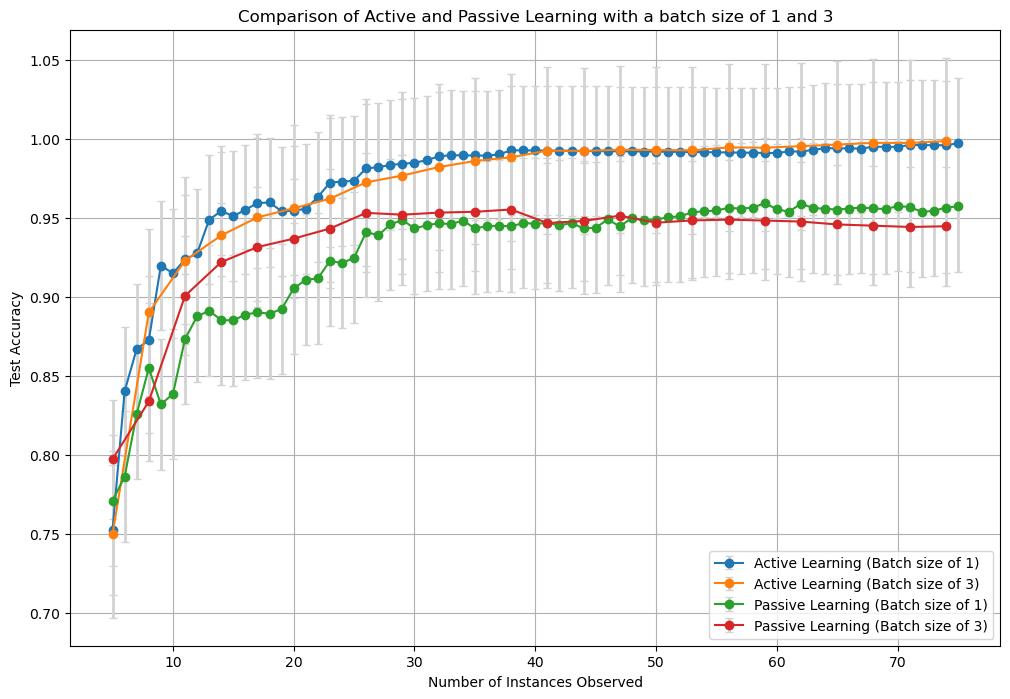

In [8]:
x_values_batch_1 = np.arange(5, 5 + len(batch_1_avg_acc_passive) * 1 , 1) 
x_values_batch_3 = np.arange(5, 5 + len(batch_3_avg_acc_passive) * 3 , 3)  

plt.figure(figsize=(12, 8))
plt.errorbar(x_values_batch_1, batch_1_avg_acc_active, yerr=np.std(batch_1_avg_acc_active), label='Active Learning (Batch size of 1)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_3, batch_3_avg_acc_active, yerr=np.std(batch_3_avg_acc_active), label='Active Learning (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_1, batch_1_avg_acc_passive, yerr=np.std(batch_1_avg_acc_passive), label='Passive Learning (Batch size of 1)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_3, batch_3_avg_acc_passive, yerr=np.std(batch_3_avg_acc_passive), label='Passive Learning (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)

plt.title('Comparison of Active and Passive Learning with a batch size of 1 and 3')
plt.xlabel('Number of Instances Observed')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## 1b. Batch-wise diversity-based sampling

In [25]:
def batch_diversity_sampling(data, seed, batch_size):
    # Store average test accuracy using unseen data
    test_acc = []
    data = shuffle(data, random_state=seed)

    # Start with five (5) random observations
    test_size_fraction = 1 - (5 / len(data))
    sample_data, remaining_data = train_test_split(data, test_size=test_size_fraction, random_state=seed)
    
    # Run the loop while the sample_data includes 50% of the original data
    while len(sample_data) <= len(data) / 2:
        # Predict on the unseen data
        X_train, y_train = sample_data.iloc[:, :-1], sample_data.iloc[:, -1]
        X_test, y_test = remaining_data.iloc[:, :-1], remaining_data.iloc[:, -1]

        # Get the accuracy score on the unseen data
        mod = RandomForestClassifier(random_state=None)
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_acc.append(test_accuracy)

        if len(remaining_data) > batch_size:
            kmeans_mod = KMeans(n_clusters=batch_size, random_state=seed)
            remaining_data_X = remaining_data.iloc[:, :-1]
            kmeans_mod.fit(remaining_data_X)
            
            instances_to_add = []
            cluster_labels = kmeans_mod.labels_
            
            for i in range(batch_size):
                # Select one random point from each cluster
                cluster_samples = remaining_data[cluster_labels == i]
                random_instance = cluster_samples.sample(n=1, random_state=seed)
                instances_to_add.append(random_instance)

            # Concatenate these instances with sample_data
            instances_to_add = pd.concat(instances_to_add)
            sample_data = pd.concat([sample_data, instances_to_add], ignore_index=True)
            
            # Drop the sampled instances from 'remaining_data'
            remaining_data = remaining_data.drop(instances_to_add.index)

    return test_acc

In [29]:
# Running Batch size = 3 for Diversity Based Sampling 
diversity_based = dict() 

for seed in tqdm(random_seeds):
    test_accur = batch_diversity_sampling(shuffled_data, seed, 3)
    diversity_based[seed] = test_accur 

diversity_acc = list(diversity_based.values())
diversity_avg_acc = np.mean(diversity_acc, axis=0)


# Running Batch size = 1 for Diversity Based Sampling 
diversity_based_1 = dict() 

for seed in tqdm(random_seeds):
    test_accur = batch_diversity_sampling(shuffled_data, seed, 1)
    diversity_based_1[seed] = test_accur 

diversity_acc_1 = list(diversity_based_1.values())
diversity_avg_acc_1 = np.mean(diversity_acc_1, axis=0)

100%|██████████| 10/10 [01:01<00:00,  6.15s/it]


#### Performance Plot of Passive Learning (Batch sizes 1 and 3), Active Learning using uncertainty sampling (Batch sizes 1 and 3), and Diversity Based Sampling (Batch size 3)

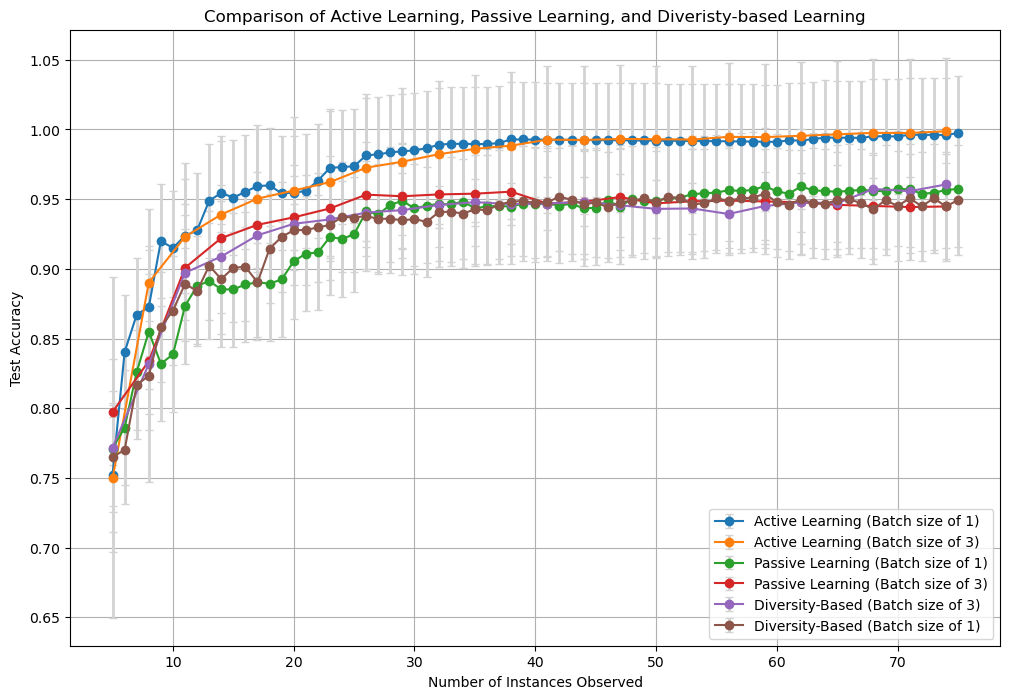

In [30]:
x_values_diversity_batch_3 = np.arange(5, 5 + len(diversity_avg_acc) * 3, 3)
x_values_diversity_batch_1 = np.arange(5, 5 + len(diversity_avg_acc_1) * 1, 1)
x_values_batch_1 = np.arange(5, 5 + len(batch_1_avg_acc_passive) * 1,  1)  
x_values_batch_3 = np.arange(5, 5 + len(batch_3_avg_acc_passive) * 3, 3) 


plt.figure(figsize=(12, 8))
plt.errorbar(x_values_batch_1, batch_1_avg_acc_active, yerr=np.std(batch_1_avg_acc_active), label='Active Learning (Batch size of 1)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_3, batch_3_avg_acc_active, yerr=np.std(batch_3_avg_acc_active), label='Active Learning (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_1, batch_1_avg_acc_passive, yerr=np.std(batch_1_avg_acc_passive), label='Passive Learning (Batch size of 1)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_3, batch_3_avg_acc_passive, yerr=np.std(batch_3_avg_acc_passive), label='Passive Learning (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_diversity_batch_3, diversity_avg_acc, yerr=np.std(diversity_acc, axis=0), label='Diversity-Based (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_diversity_batch_1, diversity_avg_acc_1, yerr=np.std(diversity_avg_acc_1, axis=0), label='Diversity-Based (Batch size of 1)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)



plt.title('Comparison of Active Learning, Passive Learning, and Diveristy-based Learning')
plt.xlabel('Number of Instances Observed')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## 1c. Hoi et al

In [13]:
def information_gain(S, idx, model, X, delta):
    
    D_class_probs = model.predict_proba(X)
    D_class_probs_prod = np.prod(D_class_probs, axis=1)
    D_class_probs_adjusted = D_class_probs_prod*(1-D_class_probs_prod)
    S_complement = S_complement = [i for i in range(len(X)) if i not in S]
    f_value = 0
    for y in S_complement:
        if y == idx:
            denominator = 0
            for x_prime in S:
                denominator+= D_class_probs_adjusted[x_prime]*np.dot(X[y], X[x_prime])**2
            f_value += D_class_probs_adjusted[y]/(delta+denominator)
        else:
            first_term = 0
            second_term = 0
            denom = delta
            for x_prime in S:
                denom+= D_class_probs_adjusted[x_prime]*np.dot(X[y], X[x_prime])**2
            first_term = D_class_probs_adjusted[y]/denom
            second_term = D_class_probs_adjusted[y]/(denom + D_class_probs_adjusted[idx]*np.dot(X[y], X[idx])**2)
            f_value += first_term - second_term
    return f_value
        

In [14]:
def get_subset(X, model, delta, batch_size):
    S = []
    for _ in range(batch_size):
        max_gain = float('-inf')
        max_gain_instance = None 
        for i in range(len(X)):
            if i not in S:
                # Calculate marginal gain f(S ∪ {x}) − f(S), hypothetical gain if this instance were to be added
                info_gain = information_gain(S, i, model, X, delta)
                if info_gain > max_gain:
                    max_gain = info_gain
                    max_gain_instance = i
        S.append(max_gain_instance)
    return S

In [15]:
def greedy_batch_active_learning(d_array, seed, batch_size):
    test_acc = []
    d_array = shuffle(d_array, random_state=seed)

    # Start with five (5) random observations 
    num_samples = len(d_array)
    initial_samples = 5
    test_size_fraction = 1 - (initial_samples / num_samples)
    sample_data, remaining_data = train_test_split(d_array, test_size=test_size_fraction, random_state=seed)

    sample_data_X, sample_data_y = sample_data[:, :-1], sample_data[:, -1]  
    remaining_data_X, remaining_data_y = remaining_data[:, :-1], remaining_data[:, -1]
    

    while len(sample_data_X) <= len(d_array) /2 :

        # Predict on the seen data
        mod = RandomForestClassifier(random_state=None)
        mod.fit(sample_data_X, sample_data_y)
        y_pred = mod.predict(remaining_data_X)
        # Get the accuracy score on the unseen data 
        test_accuracy = accuracy_score(remaining_data_y, y_pred)
        test_acc.append(test_accuracy)
        
        # Select the subset of indices for the batch
        subset_indices = get_subset(remaining_data_X, mod, delta=0.0001, batch_size=batch_size)
       
        # Add the selected subset to the sample data
        sample_data_X = np.vstack((sample_data_X, remaining_data_X[subset_indices]))
        sample_data_y = np.concatenate((sample_data_y, remaining_data_y[subset_indices]))
       
        # Remove the selected subset from the remaining data
        remaining_data_X = np.delete(remaining_data_X, subset_indices, axis=0)
        remaining_data_y = np.delete(remaining_data_y, subset_indices)
    
    return test_acc


In [16]:
# Running Greedy Based algorithm for batch size 3
greedy_batch = dict() 

for seed in tqdm(random_seeds):
    test_accur = greedy_batch_active_learning(data_array, seed, 3)
    greedy_batch[seed] = test_accur 

greedy_acc = list(greedy_batch.values())
greedy_avg_acc = np.mean(greedy_acc, axis=0)

100%|██████████| 10/10 [05:24<00:00, 32.44s/it]


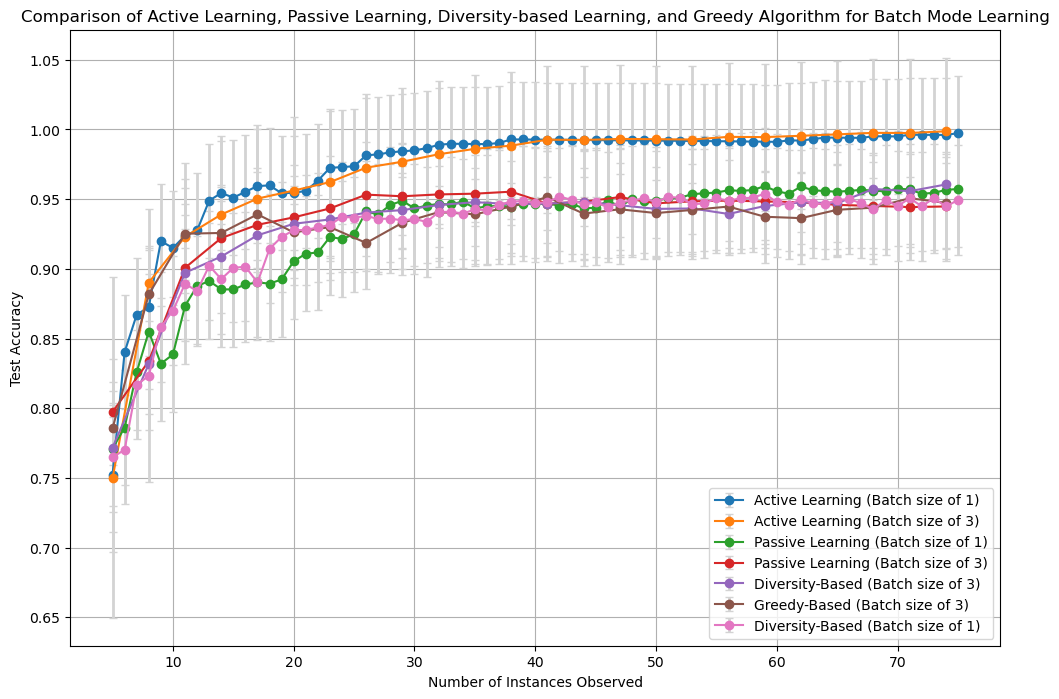

In [31]:
x_values_greedy_batch_3 = np.arange(5, 5 + len(greedy_avg_acc) * 3, 3)


plt.figure(figsize=(12, 8))
plt.errorbar(x_values_batch_1, batch_1_avg_acc_active, yerr=np.std(batch_1_avg_acc_active), label='Active Learning (Batch size of 1)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_3, batch_3_avg_acc_active, yerr=np.std(batch_3_avg_acc_active), label='Active Learning (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_1, batch_1_avg_acc_passive, yerr=np.std(batch_1_avg_acc_passive), label='Passive Learning (Batch size of 1)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_batch_3, batch_3_avg_acc_passive, yerr=np.std(batch_3_avg_acc_passive), label='Passive Learning (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_diversity_batch_3, diversity_avg_acc, yerr=np.std(diversity_acc, axis=0), label='Diversity-Based (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_greedy_batch_3, greedy_avg_acc, yerr=np.std(greedy_avg_acc), label='Greedy-Based (Batch size of 3)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)
plt.errorbar(x_values_diversity_batch_1, diversity_avg_acc_1, yerr=np.std(diversity_avg_acc_1, axis=0), label='Diversity-Based (Batch size of 1)', marker='o', ecolor='lightgray', elinewidth=2, capsize=3)


plt.title('Comparison of Active Learning, Passive Learning, Diversity-based Learning, and Greedy Algorithm for Batch Mode Learning')
plt.xlabel('Number of Instances Observed')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()
